<a href="https://colab.research.google.com/github/jwang44/upgraded-octo-chainsaw/blob/main/ConvNet_LENET5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd '/content/drive/MyDrive/imageunderstanding'
!ls

In [3]:
%cd '/content/drive/MyDrive/551 A3'
!ls

/content/drive/MyDrive/551 A3
 accu.png		       Train_labels.csv
 ExampleSubmissionRandom.csv   Train.pkl
 LoadData.ipynb		       VAL_ACCU_RES18.csv
 piechart.png		       VAL_ACCU_RES18_ROTATE.csv
 Test.pkl		       VAL_ACCU_RES34.csv
'Train_labels (1).csv'	       VAL_ACCU_TUTOR.csv


In [4]:
TRAIN_DATA_PATH = "Train.pkl"
TRAIN_LABEL_PATH = "Train_labels.csv"
TEST_DATA_PATH = "Test.pkl"
CSV_OUTPUT_PATH = "PRED_RESULT.csv"

In [5]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image
import torch
import pandas as pd

In [6]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [7]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)

## Dataset Class / Data Loaders

In [8]:
IMG_SIZE = (32, 32)

In [9]:
# Transforms are common image transformations. They can be chained together using Compose.
# Here we normalize images img=(img-0.5)/0.5
img_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize([0.5], [0.5]),
    transforms.Resize(IMG_SIZE)  
    # transforms.RandomRotation(10, resample=PIL.Image.BILINEAR)
    # transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0)
    # transforms.RandomAffine(degrees, translate=None, scale=None, shear=None, interpolation=<InterpolationMode.NEAREST: 'nearest'>, fill=0, fillcolor=None, resample=None)
])

In [10]:
# img_file: the pickle file containing the images
# label_file: the .csv file containing the labels
# transform: We use it for normalizing images (see above)
# idx: This is a binary vector that is useful for creating training and validation set.
# It return only samples where idx is True

class MyDataset(Dataset):
    def __init__(self, img_file, label_file, transform=None, idx = None):
        self.data = pickle.load( open( img_file, 'rb' ), encoding='bytes')
        self.targets = np.genfromtxt(label_file, delimiter=',', skip_header=1, usecols=1) #[:,1:]
        if idx is not None:
          self.targets = self.targets[idx]
          self.data = self.data[idx]
        self.transform = transform

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        img, target = self.data[index].squeeze(), int(self.targets[index])
        img = Image.fromarray((img*255).astype('uint8'), mode='L')
        if self.transform is not None:
           img = self.transform(img)
        return img, target

Get loader for all train data

In [11]:
BATCH_SIZE = 128
dataset = MyDataset(TRAIN_DATA_PATH, TRAIN_LABEL_PATH,transform=img_transform, idx=None)
# dataloader for all data
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

Get loaders for train/val data

In [12]:
VAL_SPLIT = 0.15
shuffle = True

# Creating indices for train and val split:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(VAL_SPLIT * dataset_size))
if shuffle:
  # set random seed so that we get the same split everytime
  np.random.seed(0)
  np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_dataset = MyDataset(TRAIN_DATA_PATH, TRAIN_LABEL_PATH,transform=img_transform, idx=train_indices)
val_dataset = MyDataset(TRAIN_DATA_PATH, TRAIN_LABEL_PATH,transform=img_transform, idx=val_indices)

# separate loaders for train and val data
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Test Dataset / Loader

In [13]:
class MyTestSet(Dataset):
  def __init__(self, img_file, transform=None):
    self.data = pickle.load( open(img_file, 'rb' ), encoding='bytes')
    self.transform = transform

  def __len__(self):
    # return self.data.shape[0]
    return len(self.data)

  def __getitem__(self, index):
    img = self.data[index].squeeze()
    img = Image.fromarray((img*255).astype('uint8'), mode='L')
    if self.transform is not None:
      img = self.transform(img)
    return img

In [14]:
test_dataset = MyTestSet(TEST_DATA_PATH,transform=img_transform)
# dataloader for test data
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## LeNet5

In [15]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

In [16]:
ActFunc = {
    'Relu': nn.ReLU(True), 
    'Sig': nn.Sigmoid(),  # may vanishing gradient problems 
    'Tanh': nn.Tanh(), # may  vanishing gradient problems 
    'LeakyRelu': nn.LeakyReLU(), 
    'ELU': nn.ELU()
}

In [17]:
class LeNet5(nn.Module):
    def __init__(self, kernel_size=5,ActFunc=['Tanh']):
        super(LeNet5, self).__init__()
        # input 1*28*28
        self.conv1 = nn.Conv2d(1, 6, kernel_size)
        self.conv2 = nn.Conv2d(6, 16, kernel_size)
        self.conv3 = nn.Conv2d(16, 120, kernel_size)
        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, 10)

    def forward(self, x):
        # x = F.avg_pool2d(F.tanh(self.conv1(x)), kernel_size = (2,2),stride = 2) # 6 filters + avgpooling => 6*14*14
        # x = F.avg_pool2d(F.tanh(self.conv2(x)), kernel_size = (2,2),stride = 2) # 16 filters + avgpooling => 16*5*5
        x = F.avg_pool2d(torch.tanh(self.conv1(x)), kernel_size = (2,2),stride = 2) # 6 filters + avgpooling => 6*14*14
        x = F.avg_pool2d(torch.tanh(self.conv2(x)), kernel_size = (2,2),stride = 2) # 16 filters + avgpooling => 16*5*5
        x = torch.tanh(self.conv3(x)) # 120 filters => 120*1*1
        x = x.view(-1, 120) 
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        # x = (self.fc3(x) # output layer
        return F.softmax(x)

Let's train these. But first, create the network, the optimizer and some lists for logging the training process

In [21]:
model = LeNet5().to(DEVICE)
# optimizer = optim.SGD(tutor_model.parameters(), lr=0.01, momentum=0.5)
# optimizer = optim.SGD(tutor_model.parameters(), lr=1, momentum=0.5)
optimizer = optim.Adam(model.parameters())
# optimizer = optim.RMSprop(model.parameters())

train_losses = []
train_counter = []
val_accus = []
epochs = []
val_losses = []
val_counter = [i*len(train_loader.dataset) for i in range(3)]

### Train and test function, used many times

In [19]:
def train(epoch, model, loader):
  model.train()
  for batch_idx, (data, target) in enumerate(loader):
    optimizer.zero_grad()
    data = data.to(DEVICE)
    # print(data.shape)
    target = target.to(DEVICE)
    output = model(data)
    # print(output.shape)
    # target = torch.argmax(target, dim=1) # convert from 1-hot to 1D
    loss = F.cross_entropy(output, target) #negative log likelihood loss
    loss.backward()
    optimizer.step()
    if batch_idx % 200 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(loader.dataset),
        100. * batch_idx / len(loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(loader.dataset)))
      torch.save(model.state_dict(), '/model.pth')
      torch.save(optimizer.state_dict(), '/optimizer.pth')

def val(model, loader):
  model.eval()
  val_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in loader:
      data = data.to(DEVICE)
      target = target.to(DEVICE)
      output = model(data)
      val_loss += F.cross_entropy(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  val_loss /= len(loader.dataset)
  val_losses.append(val_loss)

  val_accu = 100. * correct / len(loader.dataset)
  val_accus.append(val_accu)
  epochs.append(epoch)

  print('Val set: Epoch: {}, Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
    epoch, val_loss, correct, len(loader.dataset),
    100. * correct / len(loader.dataset)))

In [ ]:
len(data_loader.dataset)

60000

In [ ]:
len(train_loader.dataset)

51000

Train the network

In [22]:
for epoch in range(1, 41):
  train(epoch, model, train_loader)
  val(model, val_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/51000 (0%)]	Loss: 2.303004
Train Epoch: 1 [25600/51000 (50%)]	Loss: 2.166087


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Val set: Epoch: 1, Avg. loss: 1.9973, Accuracy: 4194/9000 (46.60%)
Train Epoch: 2 [0/51000 (0%)]	Loss: 2.020764
Train Epoch: 2 [25600/51000 (50%)]	Loss: 1.906048
Val set: Epoch: 2, Avg. loss: 1.8407, Accuracy: 5704/9000 (63.38%)
Train Epoch: 3 [0/51000 (0%)]	Loss: 1.856211
Train Epoch: 3 [25600/51000 (50%)]	Loss: 1.843100
Val set: Epoch: 3, Avg. loss: 1.7756, Accuracy: 6261/9000 (69.57%)
Train Epoch: 4 [0/51000 (0%)]	Loss: 1.802596
Train Epoch: 4 [25600/51000 (50%)]	Loss: 1.775671
Val set: Epoch: 4, Avg. loss: 1.7629, Accuracy: 6339/9000 (70.43%)
Train Epoch: 5 [0/51000 (0%)]	Loss: 1.782844
Train Epoch: 5 [25600/51000 (50%)]	Loss: 1.791290
Val set: Epoch: 5, Avg. loss: 1.7224, Accuracy: 6697/9000 (74.41%)
Train Epoch: 6 [0/51000 (0%)]	Loss: 1.747457
Train Epoch: 6 [25600/51000 (50%)]	Loss: 1.733962
Val set: Epoch: 6, Avg. loss: 1.7102, Accuracy: 6778/9000 (75.31%)
Train Epoch: 7 [0/51000 (0%)]	Loss: 1.733078
Train Epoch: 7 [25600/51000 (50%)]	Loss: 1.734219
Val set: Epoch: 7, Avg. loss

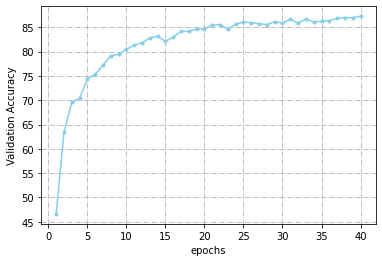

In [23]:
fig = plt.figure()
plt.plot(epochs, val_accus, color='skyblue',marker='.')
# plt.legend(['Validation Accuracy'], loc='lower right')
plt.xlabel('epochs')
plt.ylabel('Validation Accuracy')
plt.grid(linestyle='-.')

In [24]:
# convert val_accus (tensor) to list, for plotting
accu_list = []
for accu in val_accus:
  accu_list.append(accu.item())

df = pd.DataFrame(accu_list) 
df.to_csv('VAL_ACCU_LENET5.csv')

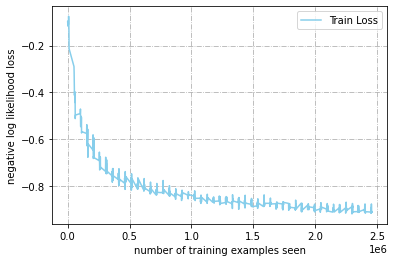

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='skyblue')
plt.legend(['Train Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.grid(linestyle='-.')

## Train on ALL data

In [ ]:
full_model = Tutor_model().to(DEVICE)
optimizer = optim.Adam(full_model.parameters())

In [ ]:
for epoch in range(1, 40):
  train(epoch, full_model, data_loader)
  val(full_model, val_loader)

## Make predictions on test data

In [ ]:
def predict(model):
  pred_test = []
  model.eval()
  with torch.no_grad():
    for data in test_loader:
      data = data.to(DEVICE)
      output = model(data)
      pred = output.data.max(1, keepdim=True)[1]
      for x in pred:
        pred_test.append(x.item())
  return pred_test

In [ ]:
pred_test = predict(full_model)
print(len(pred_test))
df_pred_test = pd.DataFrame({'id': range(10000), 'class': pred_test})
df_pred_test.to_csv(CSV_OUTPUT_PATH, index=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Length 10000
